In [1]:
import numpy as np
import scipy.io as sio
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import linalg as LA

import csv
import os
import json
import math
import time
import pickle

from glob import glob
from collections import defaultdict
from scipy import signal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from utilities import *
from utilitiesDL import *

print(torch.version.cuda)
print(torch.cuda.is_available())

11.8
True


## Parameter Configuration

In [6]:
jsonFileName = './inputJson/genWin.json'

f = open(jsonFileName)
inputJson = json.load(f)
dataPathBase = inputJson['dataPathBase']
dataType = inputJson['dataType']
cudaID = 5
f.close()

print("Datatype:", dataType)
if dataType == 'survey':
    fs = 1000 # 1 kHz
    nSubC = 30
    nRX = 3
    
    winLen = 1000
    thres = 60
    slideLen = 400

    # activities = ['bed']
    # activities = ['bed', 'fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']
    activities = ['fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']

## LSTM Network parameters
nHidden = 200
padLen = 9

# torch.manual_seed(1)
torch.set_num_threads(1)

if cudaID >= 0:
    device = torch.device("cuda:"+str(cudaID))
    cudaAvbl = True
else:
    device = torch.device("cpu")
    cudaAvbl = False

Datatype: survey


## Load windowed data

In [8]:
dataDict = {file:[] for file in activities}
for actInd, activity in enumerate(activities):
    dataDict[activity] = defaultdict(list)

    csvFileName = "/project/iarpa/wifiHAR/HAR_survey/window_pad_" + str(padLen) + "/xx_1000_" + str(thres) + "_" + activity + ".csv"
    # csvFileName = "/project/iarpa/wifiHAR/HAR_survey/window/xx_1000_" + str(thres) + "_" + activity + ".csv"

    xxLoadNP = np.array(pd.read_csv(csvFileName, header=None))
    xxLoadNPReshape = xxLoadNP.reshape((len(xxLoadNP), (winLen//2+padLen), nSubC*nRX))
    dataDict[activity]['input'] = xxLoadNPReshape
    
    dataDict[activity]['label'] = actInd*np.ones((xxLoadNP.shape[0]), dtype=int)
    print(activity+":", dataDict[activity]['input'].shape)

fall: (444, 509, 90)
pickup: (489, 509, 90)
run: (1209, 509, 90)
sitdown: (414, 509, 90)
standup: (304, 509, 90)
walk: (1467, 509, 90)


## Create training, test torch dataset

In [9]:
batchSize = 50

trData = list()
tsData = list()
for activity in activities:
    dataset = CSIDataset(dataDict[activity], device, padLen)
    nTrData = np.floor(len(dataset)*0.8).astype(int)
    nTsData = np.floor(len(dataset)*0.2).astype(int)
    # nTrData = 244
    # nTsData = 61
    # len(dataset)
    trData.append(torch.utils.data.Subset(dataset, range(nTrData)))
    tsData.append(torch.utils.data.Subset(dataset, range(nTrData, nTrData+nTsData)))
    print(activity, nTrData, nTsData, len(dataset))

trDataset = torch.utils.data.ConcatDataset(trData) # concatenating dataset lists
tsDataset = torch.utils.data.ConcatDataset(tsData)

trLoader = DataLoader(trDataset, batch_size=batchSize, shuffle=True)
tsLoader = DataLoader(tsDataset, batch_size=batchSize, shuffle=True)
print("# of tr data:", len(trDataset), "# of ts data:", len(tsDataset))

fall 355 88 444
pickup 391 97 489
run 967 241 1209
sitdown 331 82 414
standup 243 60 304
walk 1173 293 1467
# of tr data: 3460 # of ts data: 861


In [10]:
LSTMLoss = torch.nn.CrossEntropyLoss()
LR = 5e-5
maxPatience = 30
nEpoch = 200
batchSize = 200
bidirectional = True
HARNetSavePath = './savedModels/BLSTM_H_' + str(nHidden) + '_th_' + str(thres) + '_B_'\
    + str(batchSize) + '_C_' + str(len(activities)) + '.cpkt'
print('save model path:', HARNetSavePath)
fromInit = False

HARNet = LSTMNet(nClasses=len(activities), input_size=nSubC*nRX, bidirectional=bidirectional,\
                hidden_size=nHidden, num_layers=1, seq_length=winLen//2, device=device)
HARNet.to(device)

if fromInit:
    HARNet.apply(init_weights)
opt = torch.optim.Adam(HARNet.parameters(), lr=LR)

save model path: ./savedModels/BLSTM_H_200_th_60_B_200_C_6.cpkt


/home/byk004/miniconda3/envs/wifiHAR_vel/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
for trData in trLoader:
    print('outside Loader:', trData['input'].shape, trData['label'].shape)

outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50])
outside Loader: torch.Size([50, 509, 90]) torch.Size([50

## Load saved pre-trained LSTM model and evaluate (noise may be added)

In [11]:
# noiseAmpRatio = 1e-5
noiseAmpRatioList = [1e-5, 1e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 7.5e-2, 0.1, 0.2, 0.5]

nHidden = 200
thres = 60
batchSize = 200
nLayer = 1
bidirectional = False
if bidirectional:
    modelName = "BLSTM"
else:
    modelName = "LSTM"
# HARNetSavePath = './savedModels/' + modelName + '_H_' + str(nHidden) + '_th_' + str(thres) +\
#      '_L_' + str(nLayer) + '.cpkt'
HARNetSavePath = './savedModels/selected/LSTM_H_200_th_60_L_1.cpkt'

HARNet = LSTMNet(nClasses=len(activities), input_size=nSubC*nRX, bidirectional=bidirectional,\
                 hidden_size=nHidden, num_layers=nLayer, seq_length=winLen//2, device=device)
HARNet.load_state_dict(torch.load(HARNetSavePath))
HARNet.to(device)

loaderPadLen = padLen
for noiseAmpRatio in noiseAmpRatioList:
    accTest = getAcc(tsLoader, 9, HARNet, noiseAmpRatio=noiseAmpRatio, noiseType='FGM')
    print('NoiseAmpRatio:', noiseAmpRatio, ' Test accuracy:', accTest)

NoiseAmpRatio: 1e-05  Test accuracy: 0.9419279907084785
NoiseAmpRatio: 0.0001  Test accuracy: 0.9384436701509872
NoiseAmpRatio: 0.0005  Test accuracy: 0.9047619047619048
NoiseAmpRatio: 0.001  Test accuracy: 0.89198606271777
NoiseAmpRatio: 0.002  Test accuracy: 0.8362369337979094
NoiseAmpRatio: 0.005  Test accuracy: 0.6794425087108014
NoiseAmpRatio: 0.01  Test accuracy: 0.49477351916376305
NoiseAmpRatio: 0.02  Test accuracy: 0.29849012775842043
NoiseAmpRatio: 0.05  Test accuracy: 0.1997677119628339
NoiseAmpRatio: 0.075  Test accuracy: 0.18583042973286876
NoiseAmpRatio: 0.1  Test accuracy: 0.17421602787456447
NoiseAmpRatio: 0.2  Test accuracy: 0.148664343786295
NoiseAmpRatio: 0.5  Test accuracy: 0.10801393728222997


In [13]:
nDataTs = 0
for tsBatch in tsLoader:
    nDataTs += tsBatch['obs'].shape[0]

lineBreakCount = 0
for noiseAmpRatio in noiseAmpRatioList:
    correct = 0.
    for trAgentBatch in tsLoader:
        trObsBatchwoPad = trAgentBatch['obs'][:, padLen:, :]
        pred_l,label_l = getPredsGAIL(trObsBatchwoPad, trAgentBatch['FGM'], trAgentBatch['label'],\
                                        HARNet, noiseAmpRatio)
        for pred, label in zip(pred_l, label_l):
            correct += (pred == label)
    print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nDataTs), end=' ')

    lineBreakCount += 1
    if lineBreakCount == 4:
        print('')
        lineBreakCount = 0


KeyError: 'obs'

## Re-save dataset with FGM

In [11]:
nHidden = 200
thres = 60
batchSize = 200
HARNetSavePath = './savedModels/selected/LSTM_H_400_th_60_B_200_C_6.cpkt'
HARNet = LSTMNet(nClasses=len(activities), input_size=nSubC*nRX, bidirectional=False,\
                 hidden_size=nHidden, num_layers=1, seq_length=winLen//2, device=device)

for activity in activities:
    dataAct = list()
    datasetAct = CSIDataset(dataDict[activity], device)

    print(activity, len(datasetAct))

fall 444
pickup 489
run 1209
sitdown 414
standup 304
walk 1467


In [35]:
nData = 0
for actInd, activity in enumerate(activities):
    datasetAct = CSIDataset(dataDict[activity], device)
    loader = DataLoader(datasetAct, batch_size=batchSize, shuffle=False)

    for batch in loader:
        nData += batch['input'].shape[0]
print('nData:', nData, end=' ')


correct = 0.
for actInd, activity in enumerate(activities):
    datasetAct = CSIDataset(dataDict[activity], device)

    model = HARNet
    loader = DataLoader(datasetAct, batch_size=batchSize, shuffle=False)
    noiseAmpRatio = .01

    device = model.device
    model.to(device)
    model.train()

    dataInputPaddedAct = torch.empty((0, ((winLen//2+padLen) * nSubC*nRX))).to(device)
    dataNoiseAct = torch.empty((0, ((winLen//2) * nSubC*nRX))).to(device)
    dataInput_fileName = "/project/iarpa/wifiHAR/HAR_survey/window_FGM_pad_" +\
        str(padLen) + "/input_" + dataType + "_LSTM_H_200_th_" + str(thres) + "_L_1_" + activity + ".npy"
    dataNoise_fileName = "/project/iarpa/wifiHAR/HAR_survey/window_FGM_pad_" +\
        str(padLen) + "/noise_" + dataType + "_LSTM_H_200_th_" + str(thres) + "_L_1_" + activity + ".npy"

    for batch in loader:
        model.zero_grad()
        model.train()
        inputFlatten = batch['input'].view(batch['input'].shape[0], -1)
        noiseAmp = LA.norm(inputFlatten, dim=1) * (winLen//2) / (winLen//2 + padLen) * noiseAmpRatio

        batcchInputWoPad = batch['input'][:, padLen:, :]
        batcchInputWoPad.requires_grad = True
        loss = nn.CrossEntropyLoss()
        loss = loss(model(batcchInputWoPad), batch['label'])
        loss.backward()
        batchNoise = (batcchInputWoPad.grad.data).view(batcchInputWoPad.shape[0], -1)
        batchNoise = torch.mul(torch.div(batchNoise, LA.norm(batchNoise, dim=1).unsqueeze(1)),\
                            noiseAmp.unsqueeze(1))
        batchInput = batch['input'].view(batch['input'].shape[0], -1)

        batchLabel =\
            actInd * torch.ones_like(torch.empty(batchInput.shape[0], device=device), dtype=int)

        pred_l,label_l = getPredsGAIL(batcchInputWoPad, batchNoise, batchLabel,\
                                HARNet, noiseAmpRatio)
        for pred, label in zip(pred_l, label_l):
            correct += (pred == label)


        # print(batchInput.shape, batchNoise.shape, batcchInputWoPad.shape)
        dataInputPaddedAct = torch.cat((dataInputPaddedAct, batchInput), 0)
        dataNoiseAct = torch.cat((dataNoiseAct, batchNoise), 0)
        # print(dataInputPaddedAct.shape, dataNoiseAct.shape)

    dataInputPaddedActNp = dataInputPaddedAct.cpu().detach().numpy()
    dataNoiseActNp = dataNoiseAct.cpu().detach().numpy()
    print('activity:', activity, dataInputPaddedActNp.shape, dataNoiseActNp.shape)
    with open(dataInput_fileName, 'wb') as f:
        np.save(f, dataInputPaddedActNp)
    with open(dataNoise_fileName, 'wb') as f:
        np.save(f, dataNoiseActNp)

print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nData))


nData: 4327 activity: fall (444, 45810) (444, 45000)
[0.01, 0.057]
activity: pickup (489, 45810) (489, 45000)
[0.01, 0.123]
activity: run (1209, 45810) (1209, 45000)
[0.01, 0.284]
activity: sitdown (414, 45810) (414, 45000)
[0.01, 0.336]
activity: standup (304, 45810) (304, 45000)
[0.01, 0.361]
activity: walk (1467, 45810) (1467, 45000)
[0.01, 0.567]


In [35]:
testTensor = np.load(dataInput_fileName)
print(testTensor.shape)

(1467, 45810)


## Confusion Matrix

[Text(0, 0, 'fall'),
 Text(0, 1, 'Lie down'),
 Text(0, 2, 'run'),
 Text(0, 3, 'sitdown'),
 Text(0, 4, 'standup'),
 Text(0, 5, 'walk')]

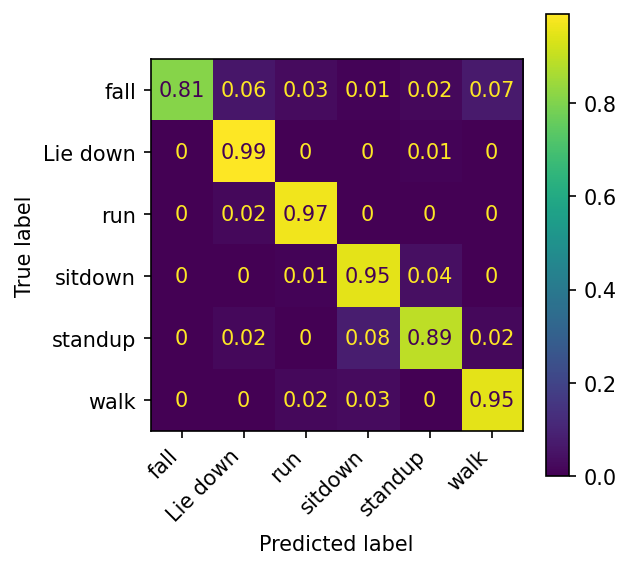

In [9]:
noiseAmpRatio = 0.0
pred, target = getPreds(tsLoader, HARNet, noiseAmpRatio=noiseAmpRatio)
cm = confusion_matrix(target,pred,normalize ='true')
for i in range(len(activities)):
    for j in range(len(activities)):
        cm[i, j] = round(cm[i, j], 2)

activities[0] = 'Fall'
activities[1] = 'Lie down'
activities[2] = 'Run'
activities[3] = 'Sit down'
activities[4] = 'Stand up'
activities[5] = 'Walk'

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4,4), dpi =150)
disp.plot(ax=ax)

ax.set_xticklabels(activities, rotation=45, ha='right')
ax.set_yticklabels(activities)

## 2D image map of data

(1209, 500, 90)


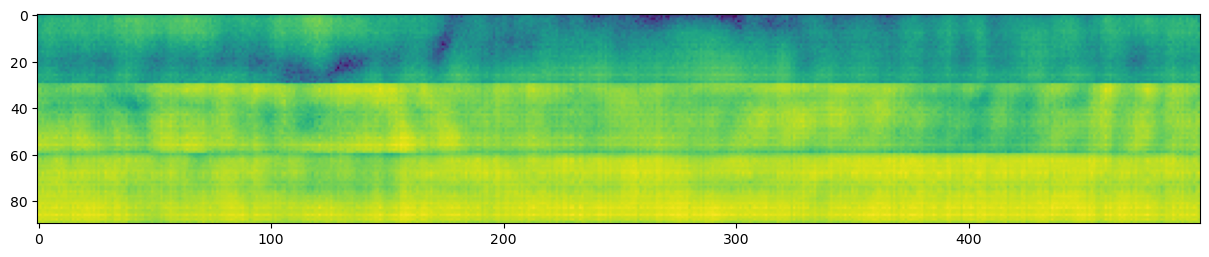

In [74]:
activity = 'run'
dataInd = 2

print(dataDict[activity]['input'].shape)
plt.figure(figsize = (15,3))
plt.imshow(dataDict[activity]['input'][dataInd,:,:].T)

## Slice CSI data with windowing and save into csv Files

In [4]:
if dataType == "survey":
    dataPath = dataPathBase + "HAR_survey/"
    dataDict = {activity:[] for activity in activities}
    for activity in activities:
        dataDict[activity] = defaultdict(list)
    windDataPath = dataPath + "window/"

elif dataType == "SHARP":
    dataPath = dataPathBase + "HAR_SHARP/"

for activity in activities:
    if dataType == "survey":
        fileNameList = glob(dataPath + "/input_" + activity + "*.csv")
        outputXXFileName = windDataPath + "xx_" + str(winLen) + "_" + str(thres) + "_" + activity + ".csv"
        outputYYFileName = windDataPath + "yy_" + str(winLen) + "_" + str(thres) + "_" + activity + ".csv"
    print('Processing', activity+", # of files:", len(fileNameList))

    xx = np.empty([0, winLen//2, nSubC*nRX], float)
    yy = np.empty([0,8], float)
    for fileIndex, fileName in enumerate(fileNameList):
        data = np.array([[float(elm) for elm in v] for v in csv.reader(open(fileName, 'r'))])
        x2 = np.empty([0, winLen//2, nSubC*nRX], float)
        # y2 = np.empty([0, 8], float)
        # print(data.shape, end=' ')

        annotFileName = fileName.replace('input', 'annotation')
        annot = np.array([[str(elm) for elm in v] for v in csv.reader(open(annotFileName, 'r'))])

        k = 0
        while k <= (len(data) + 1 - 2*winLen):
            x = np.dstack(data[k:k+winLen:2, 1:1+nSubC*nRX].T)
            ySamp = np.array(annot[k:k+winLen])
            
            bed = 0
            fall = 0
            walk = 0
            pickup = 0
            run = 0
            sitdown = 0
            standup = 0
            noactivity = 0
            for j in range(winLen):
                if ySamp[j] == "bed":
                    bed += 1
                elif ySamp[j] == "fall":
                    fall += 1
                elif ySamp[j] == "walk":
                    walk += 1
                elif ySamp[j] == "pickup":
                    pickup += 1
                elif ySamp[j] == "run":
                    run += 1
                elif ySamp[j] == "sitdown":
                    sitdown += 1
                elif ySamp[j] == "standup":
                    standup += 1
                else:
                    noactivity += 1

            if bed > winLen * thres / 100:
                yInd = 1
            elif fall > winLen * thres / 100:
                yInd = 2
            elif walk > winLen * thres / 100:
                yInd = 3
            elif pickup > winLen * thres / 100:
                yInd = 4
            elif run > winLen * thres / 100:
                yInd = 5
            elif sitdown > winLen * thres / 100:
                yInd = 6
            elif standup > winLen * thres / 100:
                yInd = 7
            else:
                yInd = 0
            
            # print(x.shape, y.shape)
            if yInd != 0:
                x2 = np.concatenate((x2, x), axis=0)
                # y2 = np.concatenate((y2, y), axis=0)
            k += slideLen

        xx = np.concatenate((xx, x2), axis=0)
        # yy = np.concatenate((yy, y2),axis=0)
        # print(y.shape)

    xx = xx.reshape(len(xx), -1)
    print(xx.shape)

    with open(outputXXFileName, "w") as f:
        writer = csv.writer(f)
        writer.writerows(xx)
    # with open(outputYYFileName, "w") as f:
    #     writer = csv.writer(f)
    #     writer.writerows(yy)

Processing bed, # of files: 79
(581, 45000)
Processing fall, # of files: 79
(367, 45000)
Processing pickup, # of files: 80
(414, 45000)
Processing run, # of files: 80
(1119, 45000)
Processing sitdown, # of files: 80
(320, 45000)
Processing standup, # of files: 79
(217, 45000)
Processing walk, # of files: 80


In [ ]:
bestAcc = 0.0
patience = 0
fastConvg = True

torch.set_num_threads(1)
print('save model path:', HARNetSavePath)
for epoch in range(nEpoch):
    runningLoss = 0.0
    HARNet.train()      
    for trIdx, trData in enumerate(trLoader):
        opt.zero_grad()
        trInput = trData['input']
        trLabel = trData['label']
        
        trOutput = HARNet(trInput)
        # print(trOutput)
        trloss = LSTMLoss(trOutput, trLabel)
        trloss.backward()
        opt.step()
        runningLoss += trloss.item()
        
    avgTrLoss = runningLoss / len(trLoader)
    accTrain = getAcc(trLoader, HARNet)

    runningLoss = 0.0
    for tsIdx, tsData in enumerate(tsLoader):
        opt.zero_grad()
        tsInput = tsData['input']
        tsLabel = tsData['label']
        
        tsOutput = HARNet(tsInput)
        tsloss = LSTMLoss(tsOutput, tsLabel)
        runningLoss += tsloss.item()

    avgTsLoss = runningLoss / len(tsLoader)
    accTest = getAcc(tsLoader, HARNet)

    print('Epoch: %d, trLoss: %.3f, trAcc: %.3f, tsLoss: %.3f, tsAcc: %.3f'\
        % (epoch, avgTrLoss, accTrain, avgTsLoss, accTest))
    if bestAcc < accTest:
        bestAcc = accTest
        print('saving model')
        torch.save(HARNet.state_dict(), HARNetSavePath)  # saving model with best test accuracy
        patience = 0

    # early stopping if model converges twice
    patience += 1
    if patience > maxPatience:
        if fastConvg:
            LR = LR/10
            opt = torch.optim.Adam(HARNet.parameters(), lr=LR)
            patience = 0
            fastConvg = False
            print('fast convergence ends')
        else:
            break

print('Training finished')